# Simulate Irreversible Expansion

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from scipy.optimize import curve_fit
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
import pickle

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_paper/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [31]:
spm.variables.search("loss")

Loss of active material in negative electrode [%]
Loss of active material in positive electrode [%]
Loss of capacity to SEI [A.h]
Loss of capacity to SEI on cracks [A.h]
Loss of capacity to lithium plating [A.h]
Loss of lithium inventory [%]
Loss of lithium inventory, including electrolyte [%]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Loss of lithium to lithium plating [mol]
Negative electrode ohmic losses
Negative electrode ohmic losses [V]
Positive electrode ohmic losses
Positive electrode ohmic losses [V]
X-averaged battery electrolyte ohmic losses [V]
X-averaged battery solid phase ohmic losses [V]
X-averaged electrolyte ohmic losses
X-averaged electrolyte ohmic losses [V]
X-averaged negative electrode ohmic losses
X-averaged negative electrode ohmic losses [V]
X-averaged positive electrode ohmic losses
X-averaged positive electrode ohmic losses [V]
X-averaged solid phase ohmic losses
X-averaged solid phase ohmic losses [V]


In [3]:
cells = [1,4,10]
sno = 17
sim_des = f'cond{sno}'
irrev_exp_data=[]
del_sei=[]; del_li=[]; es_ic_n=[]; es_ic_p=[]; n_li_loss = []
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = np.append(del_sei,(df["X-averaged SEI thickness [m]"][Ns]-df["X-averaged SEI thickness [m]"][0]))
    del_li = np.append(del_li,df["X-averaged lithium plating thickness [m]"][Ns])
    es_ic_n = np.append(es_ic_n,(-df["X-averaged negative electrode active material volume fraction"][Ns]+df["X-averaged negative electrode active material volume fraction"][0])) 
    es_ic_p = np.append(es_ic_p,(-df["X-averaged positive electrode active material volume fraction"][Ns]+df["X-averaged positive electrode active material volume fraction"][0])) 
    irrev_exp_data = np.append(irrev_exp_data,dfe["irrev_exp"].to_numpy())
    

In [56]:
cells = [1]
sno = 17
sim_des = f'cond{sno}'
irrev_exp_data=[]
del_sei=[]; del_li=[]; es_ic_n=[]; es_ic_p=[]; es_n = [];  n_li_loss = []; n_li_loss_SEI = []; nLi_data =[]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = np.append(del_sei,(df["X-averaged SEI thickness [m]"][Ns]-df["X-averaged SEI thickness [m]"][0]))
    del_li = np.append(del_li,df["X-averaged lithium plating thickness [m]"][Ns])
    es_ic_n = np.append(es_ic_n,(-df["X-averaged negative electrode active material volume fraction"][Ns]+df["X-averaged negative electrode active material volume fraction"][0]))
    es_n = np.append(es_n,(df["X-averaged negative electrode active material volume fraction"][Ns]))
    n_li_loss = np.append(n_li_loss,df["Total lithium lost [mol]"][Ns])
    n_li_loss_SEI = np.append(n_li_loss_SEI,df["Loss of lithium to SEI [mol]"][Ns])
    es_ic_p = np.append(es_ic_p,(-df["X-averaged positive electrode active material volume fraction"][Ns]+df["X-averaged positive electrode active material volume fraction"][0])) 
    irrev_exp_data = np.append(irrev_exp_data,dfe["irrev_exp"].to_numpy())
    nLi_data = np.append(nLi_data,dfe["n_Li"].to_numpy())
n_li_loss_data = nLi_data[0] - nLi_data 

In [57]:
n_li_loss_data

array([0.        , 0.00525426, 0.00953735, 0.01331348, 0.01561832,
       0.01988554, 0.02520565, 0.03336258, 0.03873143, 0.04887921])

In [58]:
n_li_loss

array([-5.55111512e-17,  2.43339206e-03,  7.90413772e-03,  1.28247022e-02,
        1.82926164e-02,  2.36337321e-02,  2.88639032e-02,  3.39985985e-02,
        3.90532867e-02,  4.40434367e-02])

In [53]:
n_li_loss_SEI/irrev_exp_SEI

C:\Users\spannala\AppData\Local\Temp\1\ipykernel_33100\2522816866.py:1: RuntimeWarning: invalid value encountered in true_divide
  n_li_loss_SEI/irrev_exp_SEI


array([       nan, 0.00014443, 0.00014885, 0.00015319, 0.00015848,
       0.00016417, 0.00017033, 0.00017702, 0.00018433, 0.00019235])

In [59]:
Rn = parameter_values.evaluate(param.n.prim.R_typ)
Rp = parameter_values.evaluate(param.p.prim.R_typ)
ln = parameter_values.evaluate(param.n.L )
lp = parameter_values.evaluate(param.p.L )
kb = 30
as_n = 3*es_n/Rn

irrev_exp_SEI = kb*as_n*ln*del_sei*1e6

In [61]:
0.4**1.5

0.2529822128134704

In [62]:
(0.4*0.9)**1.5

0.21600000000000003

C:\Users\spannala\AppData\Local\Temp\1\ipykernel_33100\1167771274.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Ns,irrev_exp_SEI*n_li_loss_data/n_li_loss_SEI,'b--')


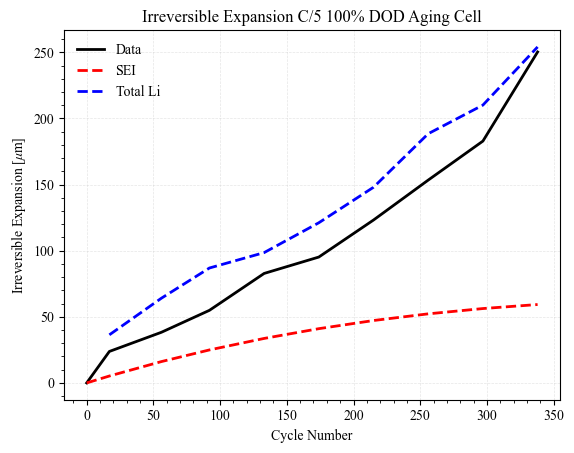

In [60]:
fig,ax = plt.subplots(1,1)
ax.plot(Ns,irrev_exp_data,'k')
ax.plot(Ns,irrev_exp_SEI,'r--')
ax.plot(Ns,irrev_exp_SEI*n_li_loss_data/n_li_loss_SEI,'b--')
ax.set_xlabel("Cycle Number")
ax.set_ylabel("Irreversible Expansion [$\mu$m]")
ax.legend(["Data","SEI","Total Li"])
ax.set_title("Irreversible Expansion C/5 100% DOD Aging Cell")
plt.savefig(fig_DIR +'irrev_expansion_model_validation.png')

## Curve Fitting

In [4]:
def fitfunc(X,b1, b2):
  del_sei,del_li=X
  out = 1e6*(b1*del_sei+b2*del_li)
  return out

ig = (100,100)
lb = 0
# lb = [-100,-100,-100,-100] 
# ub = [100,100,100,100]
ub = 1e5
popt1, pcov1 = curve_fit(fitfunc, (del_sei,del_li), irrev_exp_data,p0=ig,bounds=(lb,ub))
b1_fit = round(popt1[0],2)
b2_fit = round(popt1[1],2)
print(f"b1 fit:{b1_fit}, b2 fit:{b2_fit}")

b1 fit:744.65, b2 fit:1550.93


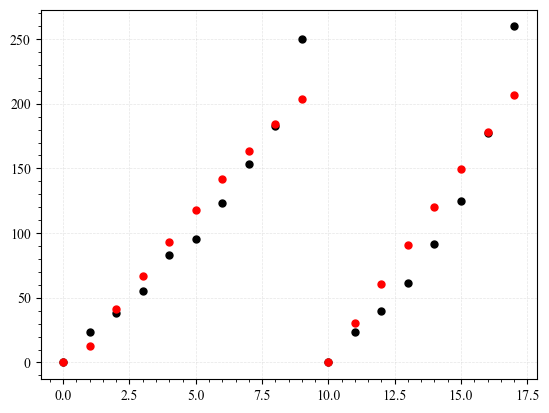

In [5]:
irrev_exp_fit = [fitfunc((del_sei[j],del_li[j]), popt1[0], popt1[1]) for j in range(len(irrev_exp_data))]
fig,ax = plt.subplots(1,1)
ax.plot(irrev_exp_data,"ko")
ax.plot(irrev_exp_fit,"ro")
plt.show()

In [6]:
b1 = b1_fit
b2 = b2_fit
b3 = 0
b4 = 0

# V2

In [205]:
# cells = [1,4]
# cells = [1,4,7,10,13,16]
cells = [1,4,10]
sno = 18
sim_des = f'cond{sno}'
irrev_exp_data=[]
del_sei=[]; del_li=[]; es_ic_n=[]; es_ic_p=[];
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = np.append(del_sei,(df["X-averaged SEI thickness [m]"][Ns]-df["X-averaged SEI thickness [m]"][0]))
    del_li = np.append(del_li,df["X-averaged lithium plating thickness [m]"][Ns])
    es_ic_n = np.append(es_ic_n,(-df["X-averaged negative electrode active material volume fraction"][Ns]+df["X-averaged negative electrode active material volume fraction"][0])) 
    es_ic_p = np.append(es_ic_p,(-df["X-averaged positive electrode active material volume fraction"][Ns]+df["X-averaged positive electrode active material volume fraction"][0])) 
    irrev_exp_data = np.append(irrev_exp_data,dfe["irrev_exp"].to_numpy())

In [206]:
def fitfunc2(X,b1, b2, b3, b4):
  del_sei,del_li,del_sei2,del_li2=X
  out = (b1*del_sei*1e6+0*b2*del_li*1e6+0*b3*del_sei2*1e12+b4*del_li2*1e12)
  return out
ig = (100,100,1000,1000)
lb = 0
# lb = [-100,-100,-100,-100] 
ub = [1e5,1e5,1e15,1e15]
# ub = 1e5
popt1, pcov1 = curve_fit(fitfunc2, (del_sei,del_li,del_sei**2,del_li**2), irrev_exp_data,p0=ig,bounds=(lb,ub))
b1_fit = round(popt1[0],2)
b2_fit = round(popt1[1],2)
b3_fit = round(popt1[2],2)
b4_fit = round(popt1[3],2)
print(f"b1 fit:{b1_fit}, b2 fit:{b2_fit}, b3 fit:{b3_fit}, b4 fit:{b4_fit}")

b1 fit:779.22, b2 fit:100.0, b3 fit:1000.0, b4 fit:17236.86


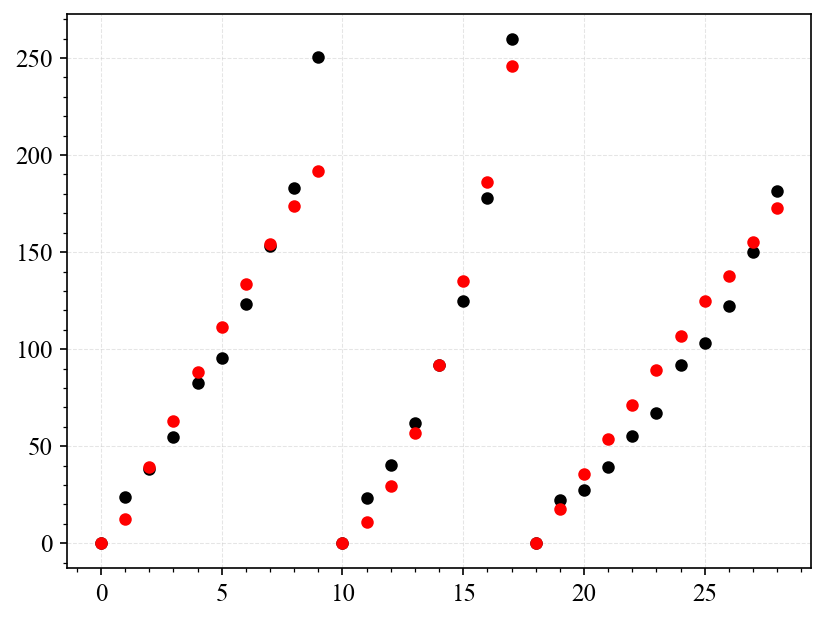

In [207]:
del_sei2 = del_sei**2
del_li2 = del_li**2
irrev_exp_fit = [fitfunc2((del_sei[j],del_li[j],del_sei2[j],del_li2[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(irrev_exp_data))]
fig,ax = plt.subplots(1,1)
ax.plot(irrev_exp_data,"ko")
ax.plot(irrev_exp_fit,"ro")
plt.show()

In [208]:
b1 = b1_fit
b2 = b2_fit
b3 = b3_fit
b4 = b4_fit
b3 = 0
b2 = 0

In [209]:
# b1 = 737.578
# b2 = 1004.319

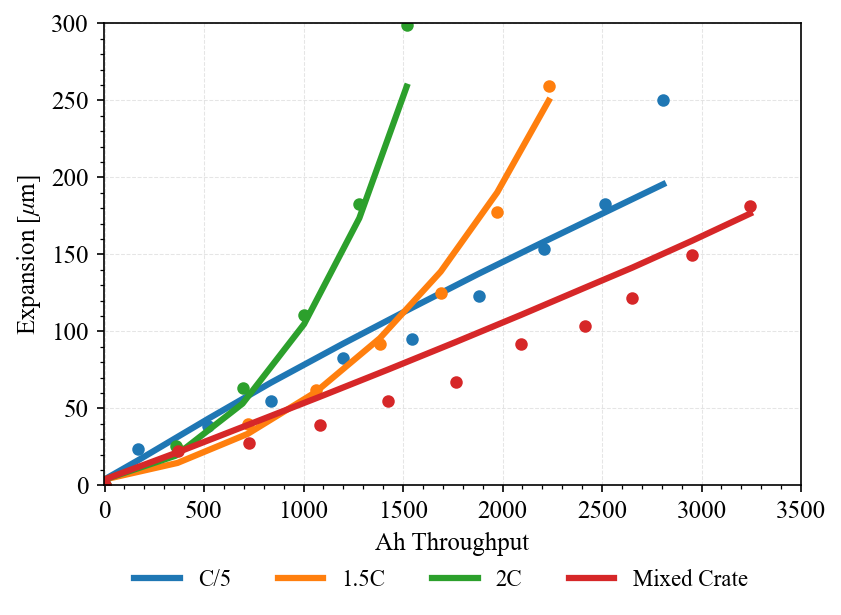

In [210]:
cells = [1,4,7,10]
# cells = [1,4]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_new_1.png')
plt.show()

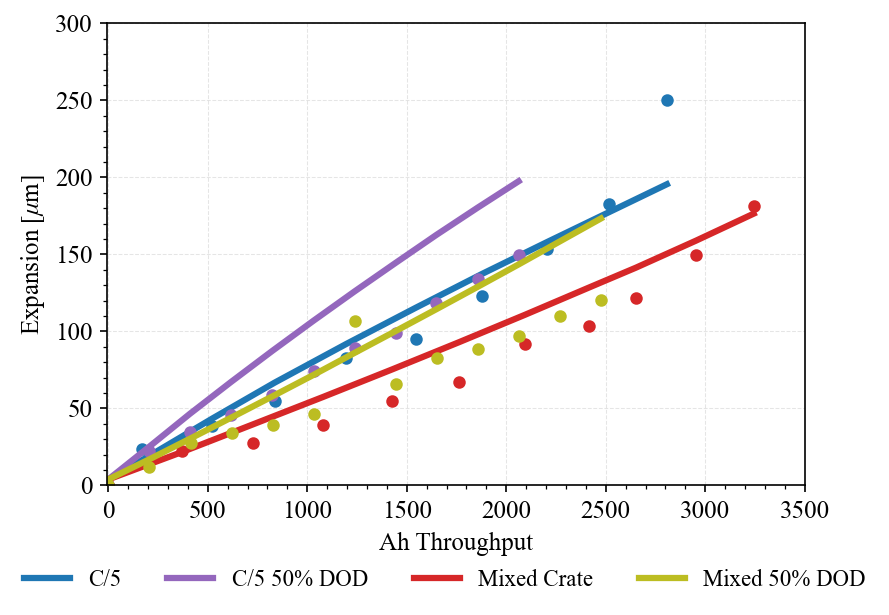

In [211]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_new_2.png')
plt.show()

In [212]:
dgdfg

NameError: name 'dgdfg' is not defined

# V3

In [3]:
# cells = [1,4]
# cells = [1,4,7,10,13,16]
cells = [1,4,10]
sno = 18
sim_des = f'cond{sno}'
irrev_exp_data=[]
del_sei=[]; del_li=[]; es_ic_n=[]; es_ic_p=[];
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = np.append(del_sei,(df["X-averaged SEI thickness [m]"][Ns]-df["X-averaged SEI thickness [m]"][0]))
    del_li = np.append(del_li,df["X-averaged lithium plating thickness [m]"][Ns])
    es_ic_n = np.append(es_ic_n,(-df["X-averaged negative electrode active material volume fraction"][Ns]+df["X-averaged negative electrode active material volume fraction"][0])) 
    es_ic_p = np.append(es_ic_p,(-df["X-averaged positive electrode active material volume fraction"][Ns]+df["X-averaged positive electrode active material volume fraction"][0])) 
    irrev_exp_data = np.append(irrev_exp_data,dfe["irrev_exp"].to_numpy())

In [4]:
Rn = parameter_values.evaluate(param.n.prim.R_typ)
Rp = parameter_values.evaluate(param.p.prim.R_typ)

In [5]:
ln = 6.2e-05
lp = 6.7e-05
Rn = 1.0e-05
Rp = 3.5e-06

In [6]:
def fitfunc3(X,b1, b2, b3, b4):
  del_sei,del_li2,es_ic_n,es_ic_p=X
  out = (b1*del_sei*1e6+b2*del_li2*1e12+b3*es_ic_n*ln*1e6+b4*es_ic_p*lp*1e6)
  out = (b1*del_sei*1e6+b2*del_li2*1e12+b3*es_ic_n+b4*es_ic_p)
  return out
ig = (100,1000,1000,1000)
lb = 0
# lb = [-100,-100,-100,-100] 
ub = [1e5,1e5,1e15,1e15]
# ub = 1e5
popt1, pcov1 = curve_fit(fitfunc3, (del_sei,del_li**2,es_ic_n,es_ic_p), irrev_exp_data,p0=ig,bounds=(lb,ub))
b1_fit = round(popt1[0],2)
b2_fit = round(popt1[1],2)
b3_fit = round(popt1[2],2)
b4_fit = round(popt1[3],2)
print(f"b1 fit:{b1_fit}, b2 fit:{b2_fit}, b3 fit:{b3_fit}, b4 fit:{b4_fit}")

b1 fit:476.14, b2 fit:5983.01, b3 fit:535.38, b4 fit:0.0


In [9]:
from scipy.optimize import rosen, differential_evolution, Bounds

In [10]:
def fitfunc_global3(x):
  # out = kb*1e6*(ln*(x[0]*e_sei+x[1]*e_li+x[2]*e_in_n)+lp*x[3]*e_in_p)
  model = np.concatenate([
         [(1e6*x[0]*del_seit+1e12*x[1]*del_li2t+x[2]*es_ic_nt+x[3]*es_ic_pt)]
        for del_seit,del_li2t,es_ic_nt,es_ic_pt in zip(del_sei,del_li**2,es_ic_n,es_ic_p)
    ]
  )
  error = irrev_exp_data-model
  out = np.linalg.norm(error)
  return out

In [11]:
bounds = Bounds([-20000., -20000., -20000., -20000.], [10000., 10000., 10000., 10000.])
bounds = Bounds([0, 0, 0, 0], [100000., 100000., 100000., 100000.])
result = differential_evolution(fitfunc_global3, bounds,seed= 312312312)
res = result.x
print(f"b1 fit:{round(res[0],2)}, b2 fit:{round(res[1],2)}, b3 fit:{round(res[2],2)}, b4 fit:{round(res[3],2)}")

b1 fit:479.81, b2 fit:5779.41, b3 fit:528.8, b4 fit:0.0


In [11]:
# del_sei2 = del_sei**2
# del_li2 = del_li**2
# irrev_exp_fit = [fitfunc3((del_sei[j],del_li2[j],es_ic_n[j],es_ic_p[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(irrev_exp_data))]
# fig,ax = plt.subplots(1,1)
# ax.plot(irrev_exp_data,"ko")
# ax.plot(irrev_exp_fit,"ro")
# plt.show()

In [12]:
b1 = b1_fit
b2 = b2_fit
b3 = b3_fit
b4 = b4_fit

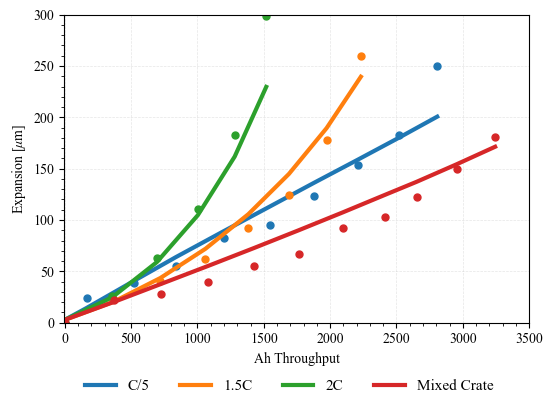

In [13]:
cells = [1,4,7,10]
# cells = [1,4]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_1.png')
plt.show()

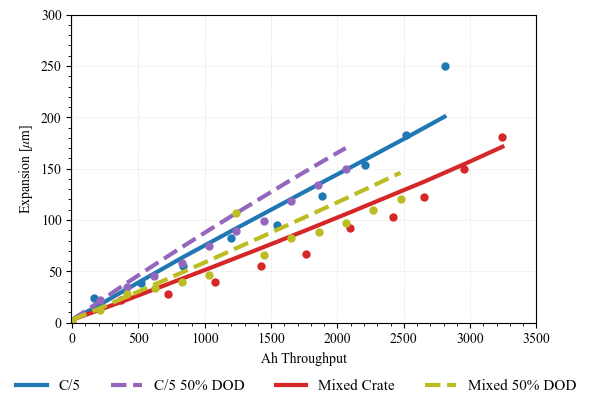

In [17]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 16 or cell == 13:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_2.png')
plt.show()

In [ ]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
sno = 7
sim_des = f'cond{sno}'
i = 0
fig, ax = plt.subplots(3,3,figsize=(12,9))
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
cycles = [0,int((len(N)+1)/2),len(N)-2]
if cell == 1:
    cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
cyc_no = cycles[0]
ax2 = ax.flat[0]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2)
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[0])
ax2.set_xlabel('Time [h]')
ax2.set_ylim(bottom=0)
ax2.set_ylabel('$I$ [A]')
cyc_no = cycles[1]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[1])
cyc_no = cycles[2]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[2])
ax2.legend(["Data","BOL","MOL","EOL"])
cells = [1,4,7]
for cell in cells:
    j=0
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    cycles = [0,int((len(N)+1)/2),len(N)-2]
    if cell == 1:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    if cell == 7:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    for cyc_no in cycles:
        print(cyc_no)
        t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
        df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
        rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
        ax1 = ax.flat[i+3]
        ax1.plot(t_d/3600,V_d,'k',linewidth=2)
        ax1.plot(df['t']/3600,df["Vt"],'r',linewidth=2,linestyle=linestyles[j])
        ax1.set_xlabel('Time [h]')
        ax1.text(0.2,0.38-0.13*j,'{}- N:{:03.0f},Ah:{:04.0f},%Cap:{:03.0f}'.format(titles[j],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100),transform=ax1.transAxes,family='monospace',fontsize='10')
        ax1.set_ylabel('$V_t$ [Ah]')
        if cell == 1:
            pass
        else:
            ax2 = ax.flat[i]
            ax2.plot(t_d/3600,I_d,'k',linewidth=2)
            ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[j])
            ax2.set_xlabel('Time [h]')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel('$I$ [A]')
        # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
        ax3 = ax.flat[i+6]
        ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
        ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r',linewidth=2,linestyle=linestyles[j])
        ax3.set_xlabel('Time [h]')
        ax3.set_ylim([0,275])
        ax3.set_ylabel('$\Delta t$ [$\mu$m]')
        # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
        j+=1
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax10.set_title("C/5 Cycling")
ax11 = ax.flat[1]
ax11.set_title("1.5C Cycling")
ax12 = ax.flat[2]
ax12.set_title("2C Cycling")
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
# ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_error_cell_all_ch.png')

In [15]:
ln = parameter_values.evaluate(param.n.L )
lp = parameter_values.evaluate(param.p.L )
kb = 30

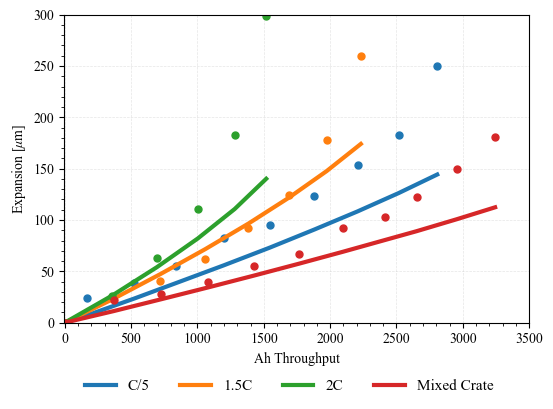

In [16]:
cells = [1,4,7,10]
# cells = [1,4]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = 1/2*kb*ln*es_ic_n*1e6
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_expansion_new_1.png')
plt.show()

# END